<a href="https://colab.research.google.com/github/lorebianchi98/BrainTumorClassification/blob/main/5_VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformers
In 2021 it was shown how the transformer architecture could be used for Image Classification . The Vision Transformer, or ViT, is a model for image classification that employs a Transformer-like architecture over patches of the image, which correspond to the word token in a NLP task. An image is split into fixed-size patches, each of them are then linearly embedded, position embeddings are added, and the resulting sequence of vectors is fed to a standard Transformer encoder. For Image classification tasks an MLP is built on top of the transformer in order to classify the image.

# Import, Costants and Installation
We need to install some packages in order to use the Vision Transformer library provided by Keras.

In [ ]:
!pip install tensorflow_addons
!pip install --quiet vit-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image
import imutils
from tqdm import tqdm
from google.colab import drive
import tensorflow_addons as tfa
from vit_keras import vit

# Connection to Google Drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
% run /content/gdrive/MyDrive/BrainTumorClassifier/utilities.ipynb

We also perform the download and the unzipping of the dataset from the drive folder.

In [ ]:
! unzip -q '/content/gdrive/MyDrive/BrainTumorClassifier/brain-tumor-mri-splits.zip' -d '/'

replace /content/brain-tumor-mri-splits/train/pituitary/Tr-pi_0273.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# Hardware Accelerator test

First we need to check if the hardware accelaration is enabled, since training a CNN on a CPU could be infeasible.

In [ ]:
#check hardware acceleration
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Dataset loading

In [ ]:
train_ds, val_ds, test_ds = load_data_splits(IMAGE_SIZE, BATCH_SIZE)

Found 4213 files belonging to 4 classes.
Found 1404 files belonging to 4 classes.
Found 1406 files belonging to 4 classes.


# Vision Transformer built from scratch
We will try to build a Vision Transformer from scratch. The code of this notebook is inspired by an [example] provided on Keras website(https://keras.io/examples/vision/image_classification_with_vision_transformer/).


Initially we set the hyperparameters. We will use as Optimizer Adam with a weight decay. With a patch size of 14 we will have 256 on our 224x224 image. The model will have 8 transformer layers and 4 heads of the MultiHead Attention layer

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
patch_size = 14  # Size of the patches to be extract from the input images
num_patches = (IMAGE_HEIGHT // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [512, 256]  # Size of the dense layers of the final classifier

## Patch visualization
As we explained before the Vision Transformer works with patches. We need to define the layer which extract the patches from the input image.

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'patch_size': self.patch_size
        })
        return config

Now we will plot an example for the extraction of the patches on a glioma image.

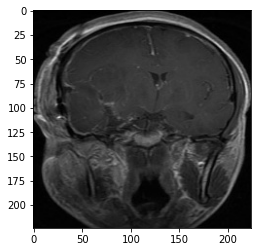

/content/brain-tumor-mri-splits/test/glioma/Te-gl_0141.jpg


In [ ]:
#glioma
first_image_glioma = os.listdir(SETS_DIR + '/test/glioma')[1]
img_path_glioma = SETS_DIR + '/test/glioma/' + first_image_glioma
# We preprocess the image into a 4D tensor (adding batch dimension)
img = image.load_img(img_path_glioma, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
img_tensor_glioma = image.img_to_array(img)
img_tensor_glioma = np.expand_dims(img_tensor_glioma, axis=0) # add batch dimension
plt.imshow(img_tensor_glioma[0].astype('uint8'))
plt.show()
print(img_path_glioma)

Image size: 224 X 224
Patch size: 14 X 14
Patches per image: 256
Elements per patch: 588


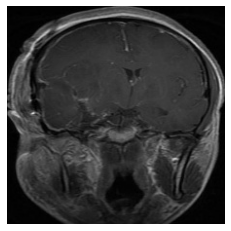

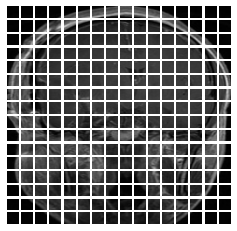

In [ ]:
plt.figure(figsize=(4, 4))
img = img_tensor_glioma[0]
plt.imshow(img.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([img]), size=IMAGE_SIZE
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {IMAGE_HEIGHT} X {IMAGE_WIDTH}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Classification

We define the function to create the MLP networks inserted in each transformer block, and the layer to encode the patches. 

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'projection': self.projection,
            'position_embedding': self.position_embedding
        })
        return config

Now we build the model and perform the training.

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    # Augment data.
    augmented = data_augmentation_layers(inputs)
    # Create patches
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.1)
    # Classify outputs.
    logits = layers.Dense(len(CLASSES))(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits, name="VisionTransformerFromScratch")
    return model

In [ ]:
model = create_vit_classifier()
model.summary()

Model: "VisionTransformerFromScratch"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_16[0][0]']               
                                                                                                  
 patches_22 (Patches)           (None, None, 588)    0           ['sequential[3][0]']             
                                                                                                  
 patch_encoder_14 (PatchEncoder  (None, 256, 64)     54080       ['patc

In [ ]:
def run_experiment(model, epochs, patience):
    monitor="val_accuracy"
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = [keras.callbacks.EarlyStopping(monitor=monitor, patience=patience), #we implement EarlyStopping to prevent overfitting
                           keras.callbacks.ModelCheckpoint(
                              checkpoint_filepath,
                              monitor=monitor,
                              save_best_only=True,
                              save_weights_only=True,
                          )]

    history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=checkpoint_callback)

    model.load_weights(checkpoint_filepath)
    

    return history



Epoch 1/100
66/66 [==============================] - 25s 223ms/step - loss: 3.5650 - accuracy: 0.2737 - val_loss: 1.5863 - val_accuracy: 0.2500
Epoch 2/100
66/66 [==============================] - 14s 200ms/step - loss: 1.3233 - accuracy: 0.3760 - val_loss: 1.3404 - val_accuracy: 0.4038
Epoch 3/100
66/66 [==============================] - 14s 208ms/step - loss: 1.2668 - accuracy: 0.3995 - val_loss: 1.1252 - val_accuracy: 0.4459
Epoch 4/100
66/66 [==============================] - 14s 200ms/step - loss: 1.0820 - accuracy: 0.4894 - val_loss: 0.9826 - val_accuracy: 0.5826
Epoch 5/100
66/66 [==============================] - 13s 200ms/step - loss: 1.0023 - accuracy: 0.5466 - val_loss: 0.8956 - val_accuracy: 0.6154
Epoch 6/100
66/66 [==============================] - 14s 206ms/step - loss: 0.8807 - accuracy: 0.6136 - val_loss: 0.8549 - val_accuracy: 0.6289
Epoch 7/100
66/66 [==============================] - 14s 201ms/step - loss: 0.7846 - accuracy: 0.6677 - val_loss: 0.7325 - val_accuracy:

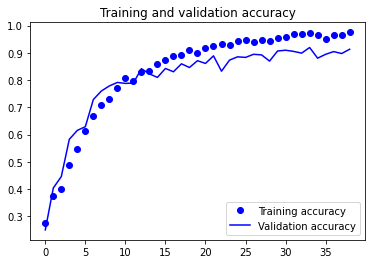

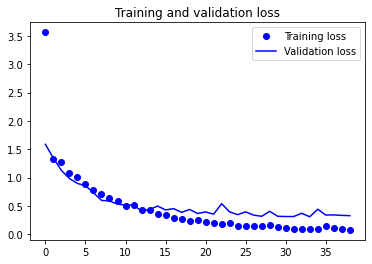

In [ ]:
history = run_experiment(model, 50, 5)
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 2s 80ms/step - loss: 0.3034 - accuracy: 0.9203
Loss on test set: 0.3033733367919922
Accuracy on test set: 0.9203413724899292
              precision    recall  f1-score   support

      glioma     0.8604    0.9292    0.8935       325
  meningioma     0.9040    0.8298    0.8653       329
     notumor     0.9630    0.9750    0.9689       400
   pituitary     0.9454    0.9347    0.9400       352

    accuracy                         0.9203      1406
   macro avg     0.9182    0.9172    0.9169      1406
weighted avg     0.9211    0.9203    0.9200      1406



22/22 [==============================] - 2s 77ms/step


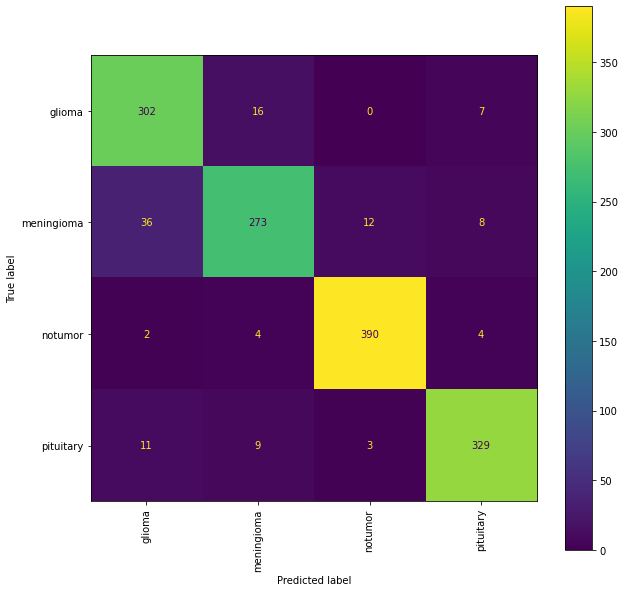

In [ ]:
plot_confusionmatrix(model, test_ds)

# Pretrained Vision Transformer
The results which reached State of the art are obtained with pretrained Vision Transformers. We will now do some experiments with a MLP built on top of a pretrained Vision Transformer.

## Base Model Loading
The first thing to do is downloading the model Vit-B32 in order to have a base for building a Brain Tumor Classifier based on this transformer.

In [ ]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = len(CLASSES))

vit_model.summary()

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


Model: "vit-b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 50, 768)          38400     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))      

##256 Dense Neurons, No dropout
We initially build a model with a 256 dense neurons layer on top of the transformer with no dropout layer. The data augmentation is used in input in order to fight overfitting.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation_layers(inputs)
x = layers.Rescaling(1./255)(x)
x = vit_model(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu', name='hidden_classifier') (x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="VisionTransformerb32_Dense256")
model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "VisionTransformerb32_Dense256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_11 (Flatten)        (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                     

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.6007 - accuracy: 0.7788
Epoch 1: val_loss improved from inf to 0.72205, saving model to model/VisionTransformerb32_Dense256.h5
66/66 [==============================] - 65s 582ms/step - loss: 0.6007 - accuracy: 0.7788 - val_loss: 0.7221 - val_accuracy: 0.7172
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.2278 - accuracy: 0.9164
Epoch 2: val_loss improved from 0.72205 to 0.51219, saving model to model/VisionTransformerb32_Dense256.h5
66/66 [==============================] - 36s 540ms/step - loss: 0.2278 - accuracy: 0.9164 - val_loss: 0.5122 - val_accuracy: 0.8298
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.1668 - accuracy: 0.9409
Epoch 3: val_loss did not improve from 0.51219
66/66 [==============================] - 32s 473ms/step - loss: 0.1668 - accuracy: 0.9409 - val_loss: 0.6589 - val_accuracy: 0.8020
Epoch 4/50
66/66 [==============================] - ETA: 0s - los

INFO:tensorflow:Assets written to: ram://2d75ae04-fc09-45b4-b86f-264ad4d4de8b/assets


INFO:tensorflow:Assets written to: ram://2d75ae04-fc09-45b4-b86f-264ad4d4de8b/assets


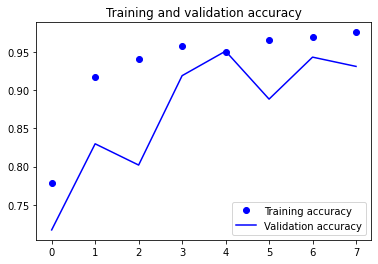

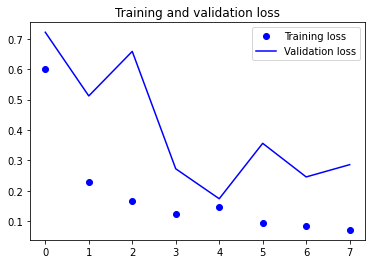

In [ ]:
model, history = run_model(model, model.name, train_ds, val_ds, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 7s 187ms/step - loss: 0.1498 - accuracy: 0.9495
Loss on test set: 0.14977815747261047
Accuracy on test set: 0.9495021104812622
              precision    recall  f1-score   support

      glioma     0.9430    0.9169    0.9298       325
  meningioma     0.9544    0.8906    0.9214       329
     notumor     0.9707    0.9950    0.9827       400
   pituitary     0.9276    0.9830    0.9545       352

    accuracy                         0.9495      1406
   macro avg     0.9489    0.9464    0.9471      1406
weighted avg     0.9497    0.9495    0.9491      1406



22/22 [==============================] - 4s 183ms/step


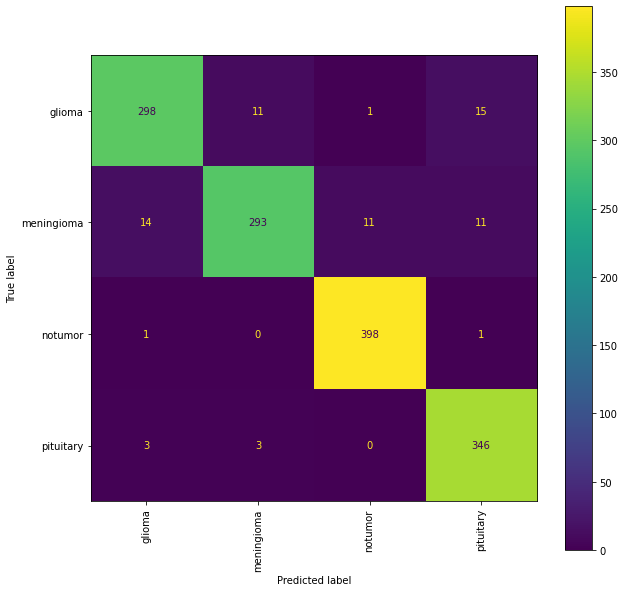

In [ ]:
plot_confusionmatrix(model, test_ds)

##256 Dense Neurons, Dropout
Since a discrete degree of overfitting was found in the first model, we try to add Dropout with a 0.3 rate.

In [ ]:
vit_model = vit.vit_b32(image_size = IMAGE_SIZE, activation = 'softmax', pretrained = True, include_top = False, pretrained_top = False, classes = len(CLASSES))
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation_layers(inputs)
x = layers.Rescaling(1./255)(x)
x = vit_model(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu', name='hidden_classifier') (x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="VisionTransformerb32_Dense256_Dropout03")
model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


Model: "VisionTransformerb32_Dense256_Dropout03"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                           

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.1645 - accuracy: 0.9452
Epoch 1: val_loss improved from inf to 0.58433, saving model to model/VisionTransformerb32_Dense256_Dropout03.h5
66/66 [==============================] - 56s 601ms/step - loss: 0.1645 - accuracy: 0.9452 - val_loss: 0.5843 - val_accuracy: 0.8191
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.9504
Epoch 2: val_loss did not improve from 0.58433
66/66 [==============================] - 32s 487ms/step - loss: 0.1545 - accuracy: 0.9504 - val_loss: 1.2367 - val_accuracy: 0.7030
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.9506
Epoch 3: val_loss improved from 0.58433 to 0.24349, saving model to model/VisionTransformerb32_Dense256_Dropout03.h5
66/66 [==============================] - 36s 538ms/step - loss: 0.1356 - accuracy: 0.9506 - val_loss: 0.2435 - val_accuracy: 0.9330
Epoch 4/50
66/66 [===========================

INFO:tensorflow:Assets written to: ram://61648c1b-b253-4d78-ad1f-fe36aeada4fe/assets


INFO:tensorflow:Assets written to: ram://61648c1b-b253-4d78-ad1f-fe36aeada4fe/assets


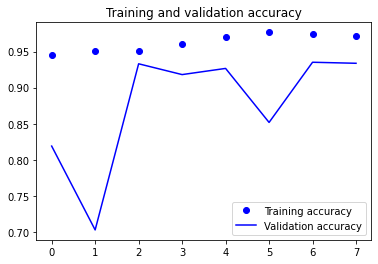

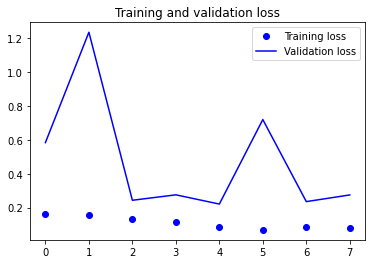

In [ ]:
model, history = run_model(model, model.name, train_ds, val_ds, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 8s 206ms/step - loss: 0.2274 - accuracy: 0.9275
Loss on test set: 0.22739535570144653
Accuracy on test set: 0.9274537563323975
              precision    recall  f1-score   support

      glioma     0.9738    0.8000    0.8784       325
  meningioma     0.8067    0.9514    0.8731       329
     notumor     0.9801    0.9850    0.9825       400
   pituitary     0.9656    0.9574    0.9615       352

    accuracy                         0.9275      1406
   macro avg     0.9315    0.9234    0.9239      1406
weighted avg     0.9344    0.9275    0.9276      1406



22/22 [==============================] - 4s 178ms/step


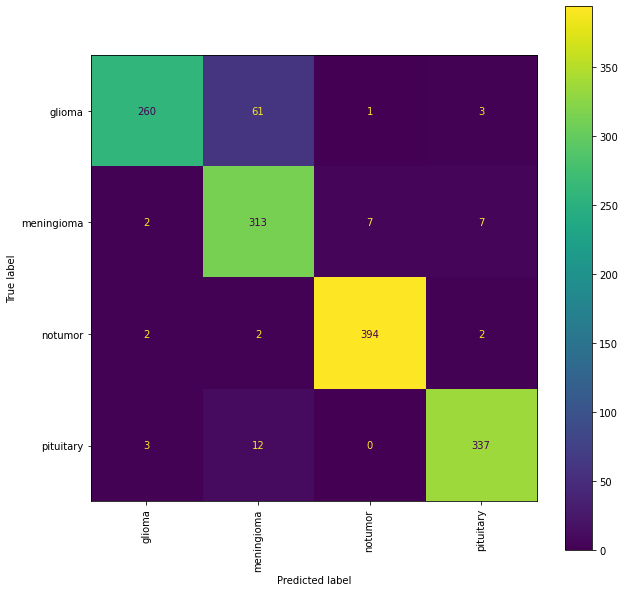

In [ ]:
plot_confusionmatrix(model, test_ds)

##First the training of the MLP network and then the fine tuning of the transformer.
In CNN we use to freeze the base network initially and train the MLP network and then in a second phase we finetune the whole network. We want to try if this procedure work also for the Vision Transformer.

In [ ]:
vit_model = vit.vit_b32(image_size = IMAGE_SIZE, activation = 'softmax', pretrained = True, include_top = False, pretrained_top = False, classes = len(CLASSES))
vit_model.trainable = False
vit_model.summary()

353263616/353253686 [==============================] - 16s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


Model: "vit-b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 50, 768)          38400     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))      

### MLP Training
We will do this experiment with the model seen before without the dropout.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation_layers(inputs)
x = layers.Rescaling(1./255)(x)
x = vit_model(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu', name='hidden_classifier') (x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="VisionTransformerb32_Dense256_Freezed")
model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "VisionTransformerb32_Dense256_Freezed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                             

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.6123 - accuracy: 0.7686
Epoch 1: val_loss improved from inf to 0.41312, saving model to model/VisionTransformerb32_Dense256_Freezed.h5
66/66 [==============================] - 44s 316ms/step - loss: 0.6123 - accuracy: 0.7686 - val_loss: 0.4131 - val_accuracy: 0.8519
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.3213 - accuracy: 0.8792
Epoch 2: val_loss improved from 0.41312 to 0.31014, saving model to model/VisionTransformerb32_Dense256_Freezed.h5
66/66 [==============================] - 18s 270ms/step - loss: 0.3213 - accuracy: 0.8792 - val_loss: 0.3101 - val_accuracy: 0.8832
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.2584 - accuracy: 0.9051
Epoch 3: val_loss improved from 0.31014 to 0.25486, saving model to model/VisionTransformerb32_Dense256_Freezed.h5
66/66 [==============================] - 18s 268ms/step - loss: 0.2584 - accuracy: 0.9051 - val_loss: 0.2549 - va

INFO:tensorflow:Assets written to: ram://38e87297-e82f-4a56-ad1d-179a9727f9e6/assets


INFO:tensorflow:Assets written to: ram://38e87297-e82f-4a56-ad1d-179a9727f9e6/assets


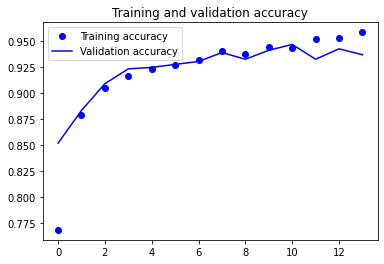

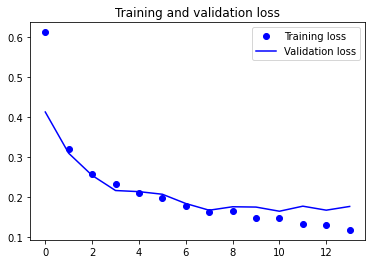

In [ ]:
model, history = run_model(model, model.name, train_ds, val_ds, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 7s 191ms/step - loss: 0.1664 - accuracy: 0.9452
Loss on test set: 0.1663682460784912
Accuracy on test set: 0.9452347159385681
              precision    recall  f1-score   support

      glioma     0.9395    0.9077    0.9233       325
  meningioma     0.9030    0.9058    0.9044       329
     notumor     0.9827    0.9925    0.9876       400
   pituitary     0.9469    0.9631    0.9549       352

    accuracy                         0.9452      1406
   macro avg     0.9430    0.9423    0.9426      1406
weighted avg     0.9451    0.9452    0.9451      1406



22/22 [==============================] - 4s 181ms/step


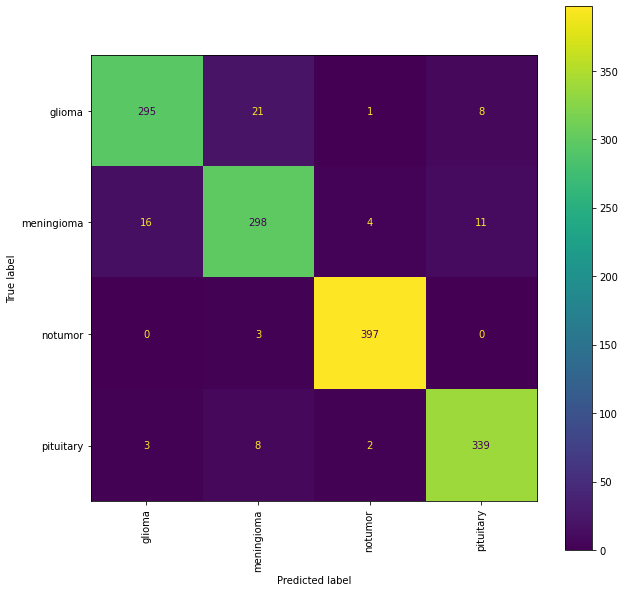

In [ ]:
plot_confusionmatrix(model, test_ds)

### Vision Transformer Fine Tuning
Now we will unfreeze the base model and perform finetuning.

In [ ]:
model.get_layer("vit-b32").trainable = True
model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0002)
model.summary()

Model: "VisionTransformerb32_Dense256_Freezed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                             

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.2709 - accuracy: 0.9046
Epoch 1: val_loss improved from inf to 1.45855, saving model to model/VisionTransformerb32_Dense256_Finetuning.h5
66/66 [==============================] - 54s 572ms/step - loss: 0.2709 - accuracy: 0.9046 - val_loss: 1.4585 - val_accuracy: 0.7023
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.9573
Epoch 2: val_loss improved from 1.45855 to 0.17195, saving model to model/VisionTransformerb32_Dense256_Finetuning.h5
66/66 [==============================] - 36s 536ms/step - loss: 0.1221 - accuracy: 0.9573 - val_loss: 0.1719 - val_accuracy: 0.9501
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9763
Epoch 3: val_loss did not improve from 0.17195
66/66 [==============================] - 32s 474ms/step - loss: 0.0725 - accuracy: 0.9763 - val_loss: 0.2149 - val_accuracy: 0.9473
Epoch 4/50
66/66 [=========================

INFO:tensorflow:Assets written to: ram://ead06ed1-ccdf-4b97-a279-ea10e3db6b51/assets


INFO:tensorflow:Assets written to: ram://ead06ed1-ccdf-4b97-a279-ea10e3db6b51/assets


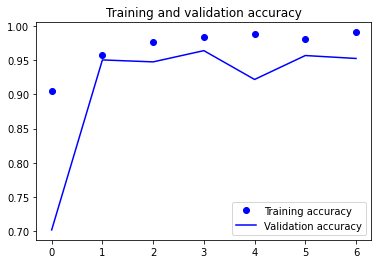

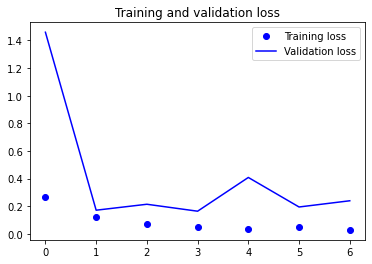

In [ ]:
model, history = run_model(model, "VisionTransformerb32_Dense256_Finetuning", train_ds, val_ds, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 7s 186ms/step - loss: 0.1521 - accuracy: 0.9651
Loss on test set: 0.1521253138780594
Accuracy on test set: 0.9651493430137634
              precision    recall  f1-score   support

      glioma     0.9428    0.9631    0.9528       325
  meningioma     0.9375    0.9574    0.9474       329
     notumor     0.9975    0.9850    0.9912       400
   pituitary     0.9767    0.9517    0.9640       352

    accuracy                         0.9651      1406
   macro avg     0.9636    0.9643    0.9639      1406
weighted avg     0.9656    0.9651    0.9653      1406



22/22 [==============================] - 4s 187ms/step


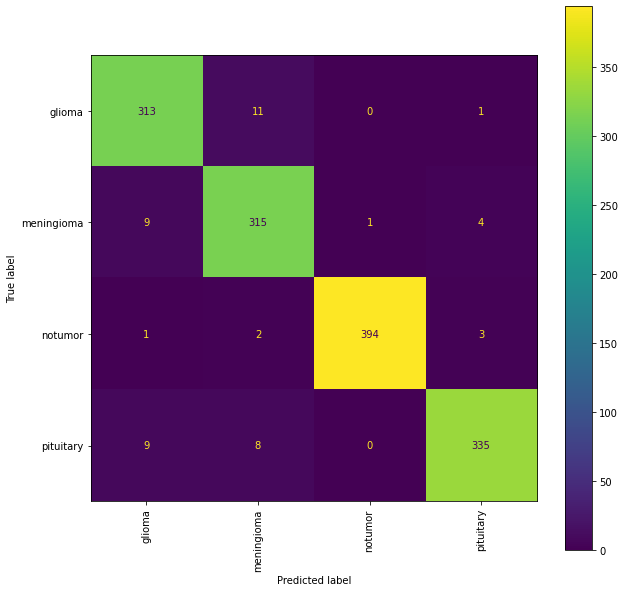

In [ ]:
plot_confusionmatrix(model, test_ds)